In [1]:
!pip install tensorflow
!pip install gym
!pip install keras
!pip install keras-rl2

In [1]:
from gym import Env
from gym.spaces import Discrete, Box
import numpy as np
import random
from matplotlib import pyplot as plt
import matplotlib.animation
from IPython.display import display, clear_output

In [2]:
code2action = {
    0:np.array([0, 0, 0, 0]),
    1:np.array([0, 0, 1, 0]),
    2:np.array([0, 0, -1, 0]),
    3:np.array([0, 0, 0, 1]),
    4:np.array([0, 0, 0, -1]),
    5:np.array([0, 0, 1, 1]),
    6:np.array([0, 0, 1, -1]),
    7:np.array([0, 0, -1, 1]),
    8:np.array([0, 0, -1, -1])
}

class ShrinkingCircleEnv(Env):
    width=height=10
    time=60
    terminated_penalty = 1
    def __init__(self):
        self.action_space = Discrete(9)
        self.bounds = np.array([self.height, self.width, self.height, self.width]) - 1
        self.observation_space = Box(np.zeros(4), self.bounds)
        
        
        self.state = (np.random.random_sample(size=4)*self.bounds).astype(int)
        
        self.circle_radius = 0
        
        self.timestamp = self.time
        
        # for rendering
        self.log_circles = []
        self.log_hero = []

        
        
    def get_reward(self):
        circle, hero = self.state[:2], self.state[2:]
        return - np.linalg.norm(hero - circle)
        
    def step(self, action):
        new_state = self.state + code2action[action]
        terminated = not ((0 <= new_state).all() and (new_state < self.bounds).all())
        
        self.state = np.clip(new_state, np.zeros(4), self.bounds)
        self.timestamp -= 1 
        self.truncated = self.timestamp<=0
        
        reward = self.get_reward()
        
        # move center of circle with probability 0.05
        if np.random.binomial(1, 0.05):
            self.state = np.hstack((
                (np.random.random_sample(size=4)*self.bounds).astype(int)[:2],
                self.state[2:]
            ))
            
        info = {}
        return self.state, reward, self.truncated, info
    
    def render(self, mode):
        circle, hero = self.state[:2], self.state[2:]
        self.log_circles.append(circle)
        self.log_hero.append(hero)
        
        if self.truncated:
            log_circles = np.unique(np.array(self.log_circles), axis=0).T
            log_hero = np.array(self.log_hero).T
            
            color = [str(item/len(log_hero[0])) for item in range(len(log_hero[0]))]
            plt.scatter(log_circles[0], log_circles[1], s=20)
            plt.scatter(log_hero[0], log_hero[1], c=color, s=20)
            plt.plot(log_hero[0], log_hero[1], color='red')
            
#             for i, point in enumerate(log_hero.T):
#                 plt.annotate(str(i), point)
                
            for i, point in enumerate(log_circles.T):
                plt.annotate(str(i), point)
            
            plt.xlim([-1, 10])
            plt.ylim([-1, 10])
            plt.grid()
            plt.show()
    
    def reset(self):
        
        self.state = (np.random.random_sample(size=4)*self.bounds).astype(int)
        self.circle_radius = 0 #min(self.height, self.width)
        self.timestamp = self.time
        
        self.log_circles = []
        self.log_hero = []
        return self.state
    

In [3]:
env = ShrinkingCircleEnv()

/homes/vladtom/miniconda3/lib/python3.10/site-packages/gym/spaces/box.py:127: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


In [4]:
episodes = 10
for episode in range(1, episodes+1):
    state = env.reset()
    done = False
    score = 0 
    
    while not done:
        #env.render()
        action = env.action_space.sample()
        n_state, reward, done, info = env.step(action)
        score+=reward
    print('Episode:{} Score:{}'.format(episode, score))

Episode:1 Score:-352.0649431246299
Episode:2 Score:-406.3344606119349
Episode:3 Score:-263.0140409641854
Episode:4 Score:-302.7758865334073
Episode:5 Score:-340.993322329208
Episode:6 Score:-267.4700345673783
Episode:7 Score:-251.17380416020364
Episode:8 Score:-237.6162536384166
Episode:9 Score:-290.73979135083476
Episode:10 Score:-355.9901451453402


### Let's learn the model

In [5]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, CategoryEncoding
from tensorflow.keras.optimizers.legacy import Adam

2023-02-23 17:55:52.696544: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-23 17:55:52.881283: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /homes/vladtom/miniconda3/lib/python3.10/site-packages/cv2/../../lib64:
2023-02-23 17:55:52.881313: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-02-23 17:55:53.660399: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfe

In [6]:
def get_model(states, n_actions=9):
    model = Sequential() 
    model.add(keras.Input(shape=(1,states[0])))
    model.add(Dense(1024, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Flatten()) 
    model.add(Dense(n_actions, activation='linear'))
    return model

In [7]:
from rl.agents import DQNAgent
from rl.policy import BoltzmannQPolicy
from rl.memory import SequentialMemory

In [8]:
def get_agent(model, actions):
    policy = BoltzmannQPolicy()
    memory = SequentialMemory(limit=50000, window_length=1)
    dqn = DQNAgent(model=model, memory=memory, policy=policy, 
                  nb_actions=actions, nb_steps_warmup=10, target_model_update=1e-2)
    return dqn

In [9]:
n_states = env.observation_space.shape
n_actions = env.action_space.n

model = get_model(n_states, n_actions)
dqn = get_agent(model, n_actions)
dqn.compile(Adam(lr=1e-3), metrics=['mae'])

/homes/vladtom/miniconda3/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
2023-02-23 17:55:55.165156: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /homes/vladtom/miniconda3/lib/python3.10/site-packages/cv2/../../lib64:
2023-02-23 17:55:55.165271: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /homes/vladtom/miniconda3/lib/python3.10/site-packages/cv2/../../lib64:
2023-02-23 17:55:55.165328: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic li

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [12]:
dqn.fit(env, nb_steps=20000, visualize=False, verbose=1)

Training for 20000 steps ...
Interval 1 (0 steps performed)
10000/10000 [==============================] - 109s 11ms/step - reward: -1.3952
166 episodes - episode_reward: -83.784 [-163.147, -43.659] - loss: 4.837 - mae: 18.441 - mean_q: -18.240

Interval 2 (10000 steps performed)
10000/10000 [==============================] - 106s 11ms/step - reward: -1.3677
done, took 215.237 seconds


Testing for 3 episodes ...


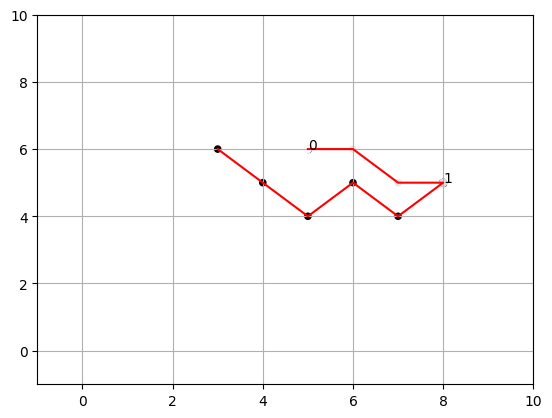

Episode 1: reward: -18.912, steps: 60


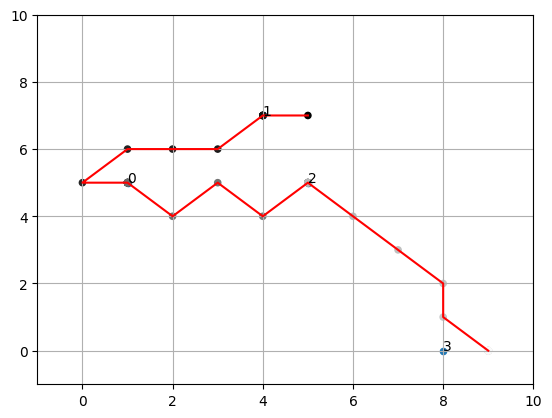

Episode 2: reward: -35.861, steps: 60


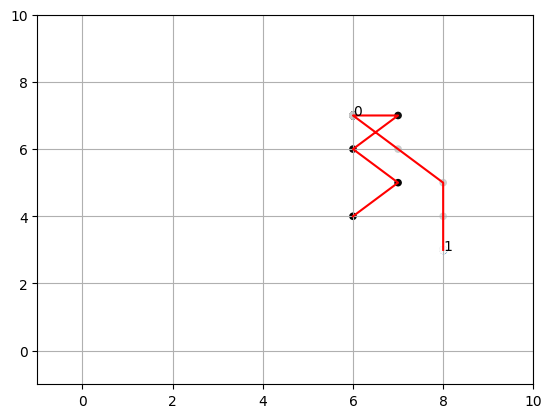

Episode 3: reward: -13.398, steps: 60
-22.72370357629484


In [13]:
scores = dqn.test(env, nb_episodes=3, visualize=True)
print(np.mean(scores.history['episode_reward']))

In [12]:
# https://stackoverflow.com/questions/25333732/matplotlib-animation-not-working-in-ipython-notebook-blank-plot